In [27]:
#from dyna_env_acdy import TaskEnv_actionD
from dyna_env_drifttype import TaskEnv_driftype
import warnings
warnings.filterwarnings('ignore')

Training PPO with fixed action space
Starting PPO training with fixed action space...
Episode 100/2000, Avg Reward: -2.42
Episode 200/2000, Avg Reward: -3.08
Episode 300/2000, Avg Reward: -4.02
Episode 400/2000, Avg Reward: -3.22
drift happen
change_frequencies function running
Episode 500/2000, Avg Reward: -5.18
Episode 600/2000, Avg Reward: -3.02
Episode 700/2000, Avg Reward: -4.20
Episode 800/2000, Avg Reward: -2.42
Episode 900/2000, Avg Reward: -1.48
Episode 1000/2000, Avg Reward: -3.16
Episode 1100/2000, Avg Reward: -4.08
Episode 1200/2000, Avg Reward: -3.00
Episode 1300/2000, Avg Reward: -2.48
Episode 1400/2000, Avg Reward: -1.86
Episode 1500/2000, Avg Reward: -3.14
Episode 1600/2000, Avg Reward: -2.90
Episode 1700/2000, Avg Reward: -2.66
Episode 1800/2000, Avg Reward: -1.06
Episode 1900/2000, Avg Reward: -2.24
Episode 2000/2000, Avg Reward: -1.80


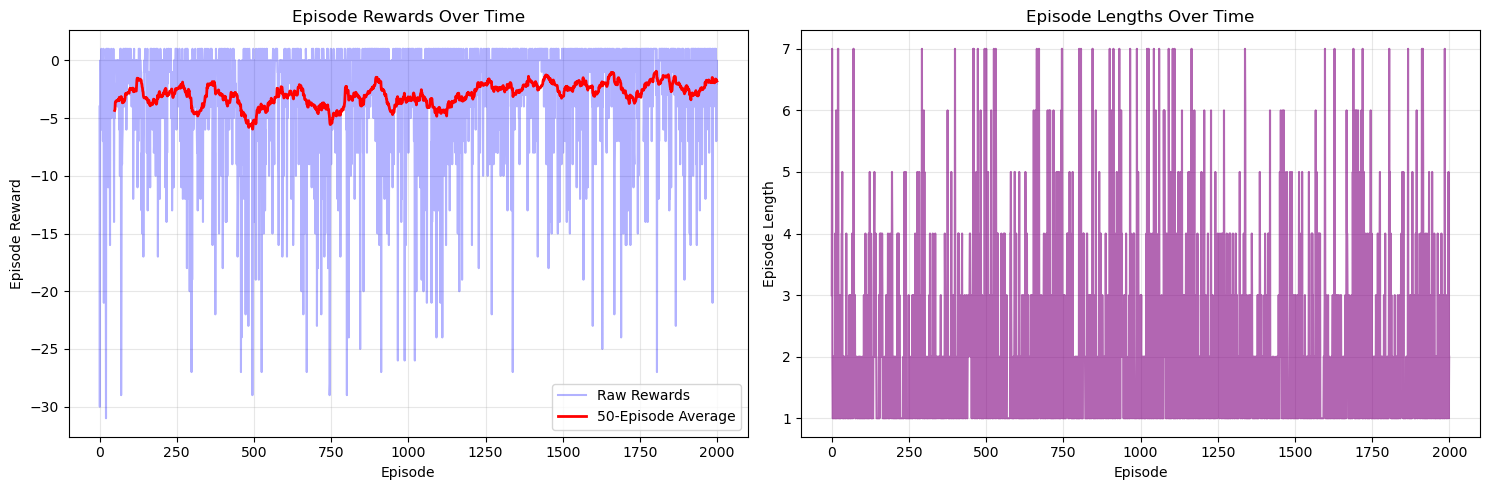


=== Training Summary ===
Mean Reward: -2.95, Std: 5.40
Mean Episode Length: 2.05
Training completed!


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
from typing import List, Tuple
import pandas as pd

# Assuming your environment is imported
# from dyna_env_drifttype import TaskEnv_driftype

class PPONetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=32):
        super(PPONetwork, self).__init__()
        
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Policy head
        self.policy_head = nn.Linear(hidden_dim, action_dim)
        
        # Value head
        self.value_head = nn.Linear(hidden_dim, 1)
        
    def forward(self, state):
        shared_out = self.shared(state)
        policy_logits = self.policy_head(shared_out)
        value = self.value_head(shared_out)
        return policy_logits, value

class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, 
                 eps_clip=0.2, k_epochs=4, entropy_coef=0.01):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.network = PPONetwork(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs
        self.entropy_coef = entropy_coef
        
        # Storage for rollouts
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.dones = []
        
    def state_to_tensor(self, state):
        """Convert state string to tensor representation"""
        # One-hot encoding for 5 states
        state_mapping = {'va': 0, 'sib': 1, 'pp': 2, 'po': 3, 'Tau': 4}
        state_vector = np.zeros(5)
        if state in state_mapping:
            state_vector[state_mapping[state]] = 1.0
        return torch.FloatTensor(state_vector).to(self.device)
    
    def select_action(self, state):
        """Select action using current policy"""
        state_tensor = self.state_to_tensor(state).unsqueeze(0)
        
        with torch.no_grad():
            logits, value = self.network(state_tensor)
            
        # Create distribution and sample
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action.item(), log_prob.item(), value.item()
    
    def store_transition(self, state, action, reward, log_prob, value, done):
        """Store transition in memory"""
        self.states.append(self.state_to_tensor(state))
        self.actions.append(action)
        self.rewards.append(reward)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.dones.append(done)
    
    def compute_gae(self, next_value=0):
        """Compute Generalized Advantage Estimation"""
        gae = 0
        returns = []
        advantages = []
        
        for i in reversed(range(len(self.rewards))):
            if i == len(self.rewards) - 1:
                next_non_terminal = 1.0 - self.dones[i]
                next_val = next_value
            else:
                next_non_terminal = 1.0 - self.dones[i+1]
                next_val = self.values[i+1]
            
            delta = self.rewards[i] + self.gamma * next_val * next_non_terminal - self.values[i]
            gae = delta + self.gamma * 0.95 * next_non_terminal * gae  # lambda = 0.95
            advantages.insert(0, gae)
            returns.insert(0, gae + self.values[i])
        
        return returns, advantages
    
    def update(self):
        """Update policy using PPO"""
        if len(self.states) == 0:
            return
        
        # Convert lists to tensors
        states = torch.stack(self.states)
        actions = torch.LongTensor(self.actions).to(self.device)
        old_log_probs = torch.FloatTensor(self.log_probs).to(self.device)
        
        # Compute returns and advantages
        returns, advantages = self.compute_gae()
        returns = torch.FloatTensor(returns).to(self.device)
        advantages = torch.FloatTensor(advantages).to(self.device)
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO update
        for _ in range(self.k_epochs):
            # Forward pass
            logits, values = self.network(states)
            
            # Create distribution
            dist = Categorical(logits=logits)
            new_log_probs = dist.log_prob(actions)
            entropy = dist.entropy().mean()
            
            # Compute ratio
            ratio = torch.exp(new_log_probs - old_log_probs)
            
            # Policy loss
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Value loss
            value_loss = F.mse_loss(values.squeeze(), returns)
            
            # Total loss
            loss = policy_loss + 0.5 * value_loss - self.entropy_coef * entropy
            
            # Update
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.network.parameters(), 0.5)
            self.optimizer.step()
    
    def clear_memory(self):
        """Clear stored transitions"""
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.log_probs.clear()
        self.values.clear()
        self.dones.clear()

def train_ppo_with_dynamic_env(total_episodes=2000, update_interval=10, change_action=False, drift_eps=400):
    """Train PPO with dynamic environment changes"""
    
    # Create environment
    env = TaskEnv_driftype()  # Note: You'll need to modify this environment to remove action masking
    
    # Create agent
    state_dim = 5  # Number of possible states
    action_dim = 7  # Fixed number of actions
    agent = PPOAgent(state_dim, action_dim)
    
    # Training tracking
    episode_rewards = []
    episode_lengths = []
    
    # Rolling averages for smoothing
    reward_window = deque(maxlen=50)
    
    print("Starting PPO training with fixed action space...")
    
    for episode in range(total_episodes):
        state = env.reset()
        episode_reward = 0
        episode_length = 0
        
        if episode == drift_eps:
            env.set_flag()
            env.drift(add_actions=0, change_at_states=['sib','pp'])
        
        # Episode rollout
        while True:
            action, log_prob, value = agent.select_action(state)
            
            try:
                next_state, reward, done, _ = env.step(action)
                
                # Check if next state is terminal
                if next_state == 'Tau':
                    done = True
                
                agent.store_transition(state, action, reward, log_prob, value, done)
                
                state = next_state
                episode_reward += reward
                episode_length += 1
                
                if done:
                    break
                    
            except ValueError as e:
                # Handle invalid action (shouldn't happen with fixed action space)
                print(f"Invalid action attempted: {e}")
                reward = -10  # Heavy penalty
                done = True
                agent.store_transition(state, action, reward, log_prob, value, done)
                break
        
        # Track metrics
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        reward_window.append(episode_reward)
        
        # Update policy
        if (episode + 1) % update_interval == 0:
            agent.update()
            agent.clear_memory()
        
        # Progress reporting
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(list(reward_window))
            print(f"Episode {episode + 1}/{total_episodes}, "
                  f"Avg Reward: {avg_reward:.2f}")
    
    return episode_rewards, episode_lengths

def visualize_training_results(episode_rewards, episode_lengths):
    """Visualize training results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    episodes = range(len(episode_rewards))
    
    # Plot 1: Episode Rewards
    ax1.plot(episodes, episode_rewards, alpha=0.3, color='blue', label='Raw Rewards')
    # Rolling average
    window_size = 50
    if len(episode_rewards) >= window_size:
        rolling_avg = pd.Series(episode_rewards).rolling(window=window_size).mean()
        ax1.plot(episodes, rolling_avg, color='red', linewidth=2, label=f'{window_size}-Episode Average')
    
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Episode Reward')
    ax1.set_title('Episode Rewards Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Episode Lengths
    ax2.plot(episodes, episode_lengths, alpha=0.6, color='purple')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Episode Length')
    ax2.set_title('Episode Lengths Over Time')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Training Summary ===")
    print(f"Mean Reward: {np.mean(episode_rewards):.2f}, Std: {np.std(episode_rewards):.2f}")
    print(f"Mean Episode Length: {np.mean(episode_lengths):.2f}")

if __name__ == "__main__":
    print("Training PPO with fixed action space")
    episode_rewards, episode_lengths = train_ppo_with_dynamic_env(
        total_episodes=2000, 
        update_interval=10,
        change_action=False
    )
    
    # Visualize results
    visualize_training_results(episode_rewards, episode_lengths)
    
    print("Training completed!")